In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from statistics import mean
from sklearn.linear_model import LinearRegression

np.random.seed(0)

In [2]:
rating_cols = ['UserID', 'MovieID', 'Rating', 'Timestamp']
users_cols = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
movies_cols = ['MovieID', 'Title', 'Genres']

ratings_df = pd.read_csv('ratings.dat', names = rating_cols,
                        header=None, sep='::', engine='python')
users_df = pd.read_csv('users.dat', names = users_cols,
                        header=None, sep='::', engine='python')
movies_df = pd.read_csv('movies.dat', names = movies_cols,
                        header=None, sep='::', engine='python')

In [3]:
print(ratings_df.head(3))
print()
print(users_df.head(3))
print()
print(movies_df.head(3))

   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968

   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117

   MovieID                    Title                        Genres
0        1         Toy Story (1995)   Animation|Children's|Comedy
1        2           Jumanji (1995)  Adventure|Children's|Fantasy
2        3  Grumpier Old Men (1995)                Comedy|Romance


In [4]:
print("ratings_df nan values:",ratings_df.isna().sum().sum())
print("users_df nan values:",users_df.isna().sum().sum())
print("movies_df nan values:",movies_df.isna().sum().sum())

ratings_df nan values: 0
users_df nan values: 0
movies_df nan values: 0


<br/><br/>
<font size="5">
First naive approach:<br/>
The predicted value is the mean of all the ratings.
</font>

In [5]:
y = ratings_df['Rating']
test_rmses=[]
test_maes=[]
train_rmses=[]
train_maes=[]

kf = KFold(random_state=0, shuffle=True)
for train_index, test_index in kf.split(y):

    R_global = ratings_df.iloc[train_index]['Rating'].mean()
    y_train = y[train_index]
    y_test = y[test_index]
    X_global_test = np.full(len(y_test), R_global)
    X_global_train = np.full(len(y_train), R_global)

    test_rmses.append(mean_squared_error(X_global_test, y_test, squared = False))
    test_maes.append(mean_absolute_error(X_global_test, y_test))
    train_rmses.append(mean_squared_error(X_global_train, y_train, squared = False))
    train_maes.append(mean_absolute_error(X_global_train, y_train))


test_rmses_GLOBAL = mean(test_rmses)
test_maes_GLOBAL = mean(test_maes)

train_rmses_GLOBAL = mean(train_rmses)
train_maes_GLOBAL = mean(train_maes)

print(f"train RMSE: {train_rmses_GLOBAL}, train MAE: {train_maes_GLOBAL}")
print(f"test RMSE: {test_rmses_GLOBAL}, test MAE: {test_maes_GLOBAL}")

train RMSE: 1.1171009275064805, train MAE: 0.9338599637316273
test RMSE: 1.1171031758416845, test MAE: 0.9338644598276286


<br/>
<br/>
<font size="5">
Second naive approach:<br/>
For each movie we take the mean value of all its ratings, so the rating prediction depends solely on the movie ratings.
</font>

In [6]:
test_rmse_movie=[]
test_mae_movie=[]

train_rmse_movie=[]
train_mae_movie=[]

kf = KFold(random_state=0 , shuffle=True)

rating_movie_split = []

for train_index, test_index in kf.split(ratings_df): 

    train = ratings_df.iloc[train_index]
    test = ratings_df.iloc[test_index]

    R_global = train['Rating'].mean()

    rating_movie = train.groupby("MovieID")['Rating'].mean()
    test_rating_movie = pd.merge(test, rating_movie, how='left', on='MovieID')
    test_rating_movie = test_rating_movie.fillna(R_global)

    train_rating_movie = pd.merge(train, rating_movie, how='left', on='MovieID')
    #train_rating_movie = train_rating_movie.fillna(R_global)
    
    
    test_rmse_movie.append(mean_squared_error(test_rating_movie['Rating_y'],test_rating_movie['Rating_x'], squared = False))
    test_mae_movie.append(mean_absolute_error(test_rating_movie['Rating_y'], test_rating_movie['Rating_x']))

    train_rmse_movie.append(mean_squared_error(train_rating_movie['Rating_y'],train_rating_movie['Rating_x'], squared = False))
    train_mae_movie.append(mean_absolute_error(train_rating_movie['Rating_y'], train_rating_movie['Rating_x']))

test_RMSE_movie = mean(test_rmse_movie)
test_MAE_movie = mean(test_mae_movie)

train_RMSE_movie = mean(train_rmse_movie)
train_MAE_movie = mean(train_mae_movie)

print(f"train RMSE: {train_RMSE_movie},train MAE: {train_MAE_movie}")
print(f"test RMSE: {test_RMSE_movie},test MAE: {test_MAE_movie}")

train RMSE: 0.9742143810479986,train MAE: 0.7783360099520757
test RMSE: 0.9794920074387622,test MAE: 0.7823951145696074


<br/><br/>
<font size="5">
Third naive approach:<br/>
For each user we calculate the mean of their ratings, so the rating of a movie depends on the user who is rating it.
</font>

In [7]:
rmse_user=[]
mae_user=[]

train_rmse_user=[]
train_mae_user=[]

rating_user_split=[]
kf = KFold(random_state=0, shuffle=True)

for train_index, test_index in kf.split(ratings_df): 

    train = ratings_df.iloc[train_index]
    test = ratings_df.iloc[test_index]

    R_global = train['Rating'].mean()

    rating_user = train.groupby("UserID")['Rating'].mean()
    test_rating_user= pd.merge(test, rating_user, how='left', on='UserID')
    test_rating_user=test_rating_user.fillna(R_global)

    train_rating_user = pd.merge(train, rating_user, how='left', on='UserID')

    rmse_user.append(mean_squared_error(test_rating_user['Rating_x'],test_rating_user['Rating_y'], squared = False))
    mae_user.append(mean_absolute_error(test_rating_user['Rating_x'], test_rating_user['Rating_y']))

    train_rmse_user.append(mean_squared_error(train_rating_user['Rating_x'],train_rating_user['Rating_y'], squared = False))
    train_mae_user.append(mean_absolute_error(train_rating_user['Rating_x'], train_rating_user['Rating_y']))

RMSE_USER = mean(rmse_user)
MAE_USER = mean(mae_user)

train_RMSE_USER = mean(train_rmse_user)
train_MAE_USER = mean(train_mae_user)

print(f"train RMSE: {train_RMSE_USER}, train MAE: {train_MAE_USER}")
print(f"test RMSE: {RMSE_USER}, test MAE: {MAE_USER}")

train RMSE: 1.027667058725022, train MAE: 0.8227820910637575
test RMSE: 1.0355315392919382, test MAE: 0.8289870840776133


<br/><br/>
<font size="5">
Forth naive approach:<br/>
Linear Regression model without intercept
</font>

In [8]:
rmse_linreg =[]
mae_linreg =[]

train_rmse_linreg =[]
train_mae_linreg =[]

for train_index, test_index in kf.split(ratings_df): 

  train_y, test_y  = ratings_df.iloc[train_index] , ratings_df.iloc[test_index] 
  R_global = train_y['Rating'].mean()

  rating_movie = train_y.groupby("MovieID")['Rating'].mean()
  rating_user = train_y.groupby("UserID")['Rating'].mean()

  rating_movie_test = test_y.groupby("MovieID")['Rating'].mean()
  rating_user_test = test_y.groupby("UserID")['Rating'].mean()

  train_X_movie = pd.merge(train_y, rating_movie, how='left', on='MovieID')
  train_X_user = pd.merge(train_y, rating_user, how='left', on='UserID')

  test_X_movie = pd.merge(test_y, rating_movie_test, how='left', on='MovieID')
  test_X_user = pd.merge(test_y, rating_user_test, how='left', on='UserID')

  test_X_movie = test_X_movie.fillna(R_global)
  test_X_user = test_X_user.fillna(R_global)


  reg = LinearRegression(fit_intercept=False)
  model = reg.fit(pd.concat([train_X_movie['Rating_y'], train_X_user['Rating_y']],axis=1), train_y['Rating'])
  coeff_intercept = model.coef_

  pred = reg.predict(pd.concat([test_X_movie['Rating_y'], test_X_user['Rating_y']],axis=1))
  train_pred = reg.predict(pd.concat([train_X_movie['Rating_y'], train_X_user['Rating_y']],axis=1))


  rmse_linreg.append(mean_squared_error(test_y['Rating'], pred, squared = False))
  mae_linreg.append(mean_absolute_error(test_y['Rating'], pred))

  train_rmse_linreg.append(mean_squared_error(train_y['Rating'], train_pred, squared = False))
  train_mae_linreg.append(mean_absolute_error(train_y['Rating'], train_pred))

RMSE_linreg = mean(rmse_linreg)
MAE_linreg = mean(mae_linreg)

train_RMSE_linreg = mean(train_rmse_linreg)
train_MAE_linreg = mean(train_mae_linreg)

print(f"last coeficients: {coeff_intercept}")
print(f"train RMSE: {train_RMSE_linreg}, train MAE: {train_MAE_linreg}")
print(f"test RMSE: {RMSE_linreg}, test MAE: {MAE_linreg}")

last coeficients: [0.63797429 0.3690965 ]
train RMSE: 0.9465472371210878, train MAE: 0.758547375237167
test RMSE: 0.9344126039394197, test MAE: 0.7486762049260492


<br/><br/>
<font size="5">
Fifth naive approach:<br/>
Linear Regression model with intercept
</font>

In [9]:
rmse_linreg =[]
mae_linreg =[]

train_rmse_linreg =[]
train_mae_linreg =[]

for train_index, test_index in kf.split(ratings_df): 

  train_y, test_y  = ratings_df.iloc[train_index] , ratings_df.iloc[test_index] 
  R_global = train_y['Rating'].mean()

  rating_movie = train_y.groupby("MovieID")['Rating'].mean()
  rating_user = train_y.groupby("UserID")['Rating'].mean()

  rating_movie_test = test_y.groupby("MovieID")['Rating'].mean()
  rating_user_test = test_y.groupby("UserID")['Rating'].mean()

  train_X_movie = pd.merge(train_y, rating_movie, how='left', on='MovieID')
  train_X_user = pd.merge(train_y, rating_user, how='left', on='UserID')

  test_X_movie = pd.merge(test_y, rating_movie_test, how='left', on='MovieID')
  test_X_user = pd.merge(test_y, rating_user_test, how='left', on='UserID')
  #test_X_movie = test_X_movie.fillna(R_global)
  #test_X_user = test_X_user.fillna(R_global)


  reg = LinearRegression()
  model = reg.fit(pd.concat([train_X_movie['Rating_y'], train_X_user['Rating_y']],axis=1), train_y['Rating'])
  coeff_intercept = model.coef_
  intercept = model.intercept_

  pred = reg.predict(pd.concat([test_X_movie['Rating_y'], test_X_user['Rating_y']],axis=1))
  train_pred = reg.predict(pd.concat([train_X_movie['Rating_y'], train_X_user['Rating_y']],axis=1))


  rmse_linreg.append(mean_squared_error(test_y['Rating'], pred, squared = False))
  mae_linreg.append(mean_absolute_error(test_y['Rating'], pred))

  train_rmse_linreg.append(mean_squared_error(train_y['Rating'], train_pred, squared = False))
  train_mae_linreg.append(mean_absolute_error(train_y['Rating'], train_pred))

RMSE_linreg = mean(rmse_linreg)
MAE_linreg = mean(mae_linreg)

train_RMSE_linreg = mean(train_rmse_linreg)
train_MAE_linreg = mean(train_mae_linreg)

print(f"train RMSE: {train_RMSE_linreg}, train MAE: {train_MAE_linreg}")
print(f"test RMSE: {RMSE_linreg}, test MAE: {MAE_linreg}")
print(f"last coeficients: {coeff_intercept}, intercept: {intercept} ")

train RMSE: 0.9146014408340464, train MAE: 0.7250398934079946
test RMSE: 0.9002114939906899, test MAE: 0.712852454127933
last coeficients: [0.87517719 0.78247085], intercept: -2.3547659068564064 


<br/><br/>
<font size="5">
UV matrix decomposition algorithm
</font>

In [10]:
def ratings_df_to_matrix(ratings_df):
    M_df = ratings_df.pivot(index='UserID',
                            columns='MovieID',
                            values='Rating'
                            )
    return M_df

In [11]:
def data_normalization(M_df):
    M_matrix = M_df.copy()
    norm_val = (np.nanmean(M_matrix,axis=1,keepdims=True) / 2) + (np.nanmean(M_matrix,axis=0,keepdims=True) / 2)
    M_matrix -= norm_val
    M_matrix = M_matrix.to_numpy(na_value=np.nan)
    return M_matrix, norm_val

In [12]:
def create_U_V_M_matrixes(ratings_df,dim=2,initial_val=None,noise_size=1,normalize=True,debug=False):

    if dim < 2:
        print("please choose a dimension grreater than 2.")
        return 0
    
    M_matrix = ratings_df_to_matrix(ratings_df)

    if normalize == True:
        M_matrix, norm_val = data_normalization(M_matrix)
        if initial_val == None:
            initial_val = 0.0
    else:
        #just in case we don't want to normalize
        M_matrix = M_matrix.to_numpy()
        if initial_val == None:
            initial_val = np.sqrt((np.nansum(np.nansum(M_matrix,axis=0)
                                ) / (np.count_nonzero(~np.isnan(M_matrix)))/dim))
        norm_val = 0.0

    #creating decomposition matrixes and adding noise
    U_matrix = np.full((len(M_matrix),dim), initial_val).astype(float)
    if noise_size > 0:
        noise = np.random.normal(0, noise_size, U_matrix.shape)
        U_matrix += noise

    V_matrix = np.full((dim,len(M_matrix[0])), initial_val).astype(float)
    if noise_size > 0:
        noise = np.random.normal(0, noise_size, V_matrix.shape)
        V_matrix += noise

    if debug:
        print("M_matrix:",M_matrix.shape)
        print(f"normalize: {normalize}")
        print("weights initialization value:",initial_val)
        print("U_matrix shape:",U_matrix.shape)
        print("V_matrix shape:",V_matrix.shape)

    return M_matrix, norm_val, U_matrix, V_matrix

In [13]:
def RMSE(targets,predictions):
    """
    Calculates the RMSE between 2 matrixes
    """
    return np.sqrt(np.nansum(np.nansum((targets - predictions) ** 2, axis=1)) / (targets.size - np.isnan(targets).sum()))


def MAE(targets, predictions):
    return np.nansum(np.nansum(np.abs((targets - predictions)), axis=1)) / (targets.size - np.isnan(targets).sum())

In [14]:
def sum_of_squares_d(U,V,M,index_row,index_col,axis):
    if axis==0:
        if np.isnan(M[index_row]).all() == True:
            #condition used if all values in M[index_row] are nan
            return U[index_row][index_col]
        u = np.delete(U[index_row],index_col)
        v = np.delete(V,index_col,0)
        return np.nansum(np.multiply(V[index_col],(M[index_row] - np.dot(u,v)))) / np.nansum(~np.isnan(M[index_row])*V[index_col]**2) #

    if axis == 1:
        if np.isnan(M[:,index_row]).all() == True:
            #condition used if all values in M[:,index_row] are nan
            return U[index_row][index_col]
        u = np.delete(U,index_row,1)
        v = np.delete(V[:,index_col],index_row)
        return np.nansum(np.multiply(U[:,index_row],(M[:,index_col] - np.dot(u,v)))) / np.nansum(~np.isnan(M[:,index_col])*U[:,index_row]**2) #

In [15]:
def denormalize_UV(UV,norm_val):
    UV += norm_val
    UV[UV>5] = 5
    UV[UV<1] = 1
    return UV

In [16]:
def evaluate_model(test_set, UV_matrix, index, columns,global_val):

    predictions_df = pd.DataFrame(UV_matrix,index=index,columns=columns)
    predictions_df = predictions_df.reset_index()
    predictions_df = pd.melt(predictions_df,id_vars=['UserID'],
                            value_vars=predictions_df.columns.drop('UserID'),
                            value_name='Predicted')

    merged = pd.merge(test_set,predictions_df, on=['UserID', 'MovieID'],how='left'
                    ).rename(columns={'Rating_x': 'Rating', 'Rating_y': 'Predicted'})

    merged['Predicted'] = merged.Predicted.fillna(global_val)
    test_RMSE = mean_squared_error(merged['Rating'], merged['Predicted'], squared=False)
    test_MAE = mean_absolute_error(merged['Rating'], merged['Predicted'])
    
    return test_RMSE, test_MAE

In [17]:
def decomposition_algorithm(ratings_df,test_df,dim=2,normalize_data=True,initial_value=None,noise_size=1,iters=15,debug=False):

    M_matrix, norm_val, U_matrix, V_matrix = create_U_V_M_matrixes(ratings_df,dim=dim,
                                                        initial_val=initial_value,noise_size=noise_size,
                                                        normalize=normalize_data,debug=debug)
    
    range_U_matrix = range(len(U_matrix))
    range_V_matrix = range(len(V_matrix[0]))
    range_d = range(dim)

    #we need this in order to keep track of the UserID and MovieID on our train set
    #in order to compare it with the test data later, and fill the gaps.
    M_df = ratings_df_to_matrix(ratings_df)
    global_val = ratings_df['Rating'].mean()
    
    TRAIN_RMSE = []
    TRAIN_MAE = []
    TEST_RMSE = []
    TEST_MAE = []
    
    #calculate initial RMSE for train and test
    UV_matrix = np.dot(U_matrix, V_matrix)
    curr_train_rmse = RMSE(M_matrix,UV_matrix)
    curr_train_mae = MAE(M_matrix,UV_matrix)
    TRAIN_RMSE.append(curr_train_rmse)
    TRAIN_MAE.append(curr_train_mae)
    #denormalize UV and calculate RMSE on test data
    UV_matrix = denormalize_UV(UV_matrix, norm_val)
    curr_test_rmse, curr_test_mae = evaluate_model(test_df, UV_matrix,
                                                    index=M_df.index,columns=M_df.columns,
                                                    global_val=global_val)
    TEST_RMSE.append(curr_test_rmse)
    TEST_MAE.append(curr_test_mae)

    
    if debug: 
        print("Mean value used to fill nan values:",global_val)
        print()
        print(f"initial train RMSE: {curr_train_rmse}, initial train MAE: {curr_train_mae}") 
        print(f"initial test RMSE: {curr_test_rmse}, initial test MAE: {curr_test_mae}") 

    #updating weights..
    for iter in range(iters):      
        for i in range_U_matrix:
            for j in range_d:
                U_matrix[i][j] = sum_of_squares_d(U_matrix,V_matrix,M_matrix,i,j,axis=0)

        for i in range_d:
            for j in range_V_matrix:
                V_matrix[i][j] = sum_of_squares_d(U_matrix,V_matrix,M_matrix,i,j,axis=1) 

        #calculate new RMSE
        UV_matrix = np.dot(U_matrix, V_matrix)
        curr_train_rmse = RMSE(M_matrix,UV_matrix) 
        curr_train_mae = MAE(M_matrix,UV_matrix) 
        TRAIN_RMSE.append(curr_train_rmse)
        TRAIN_MAE.append(curr_train_mae)
        
        #denormalize UV and calculate RMSE on test data 
        UV_matrix = denormalize_UV(UV_matrix,norm_val)
        curr_test_rmse, curr_test_mae = evaluate_model(test_df, UV_matrix,M_df.index,M_df.columns,global_val)
        TEST_RMSE.append(curr_test_rmse)
        TEST_MAE.append(curr_test_mae)
        
        if debug: 
            print(f'iteration {iter+1}, train RMSE: {curr_train_rmse}, train MAE {curr_train_mae}')
            print(f'iteration {iter+1}, test RMSE: {curr_test_rmse}, test MAE {curr_test_mae}')
            print()

    return TRAIN_RMSE, TRAIN_MAE, TEST_RMSE, TEST_MAE, U_matrix, V_matrix

In [18]:
#data k-folding

train_df = []
test_df = []

n_splits = 5

kf = KFold(n_splits=n_splits,shuffle=True)
for train_index, test_index in kf.split(ratings_df): 

    curr_train_df, curr_test_df  = ratings_df.iloc[train_index] , ratings_df.iloc[test_index]

    train_df.append(curr_train_df)
    test_df.append(curr_test_df)

In [19]:
#we will keep the dataframes to use the values of MovieID and UserID for the validation later.
M_dfs = []
for i in range(len(train_df)):
    #creating utility matrix
    M_df = train_df[i].pivot(index='UserID',
                            columns='MovieID',
                            values='Rating'
                            )
    M_dfs.append(M_df)

Test_dfs = []
for i in range(len(test_df)):
    #creating utility matrix
    M_df = test_df[i].pivot(index='UserID',
                            columns='MovieID',
                            values='Rating'
                            )
    Test_dfs.append(M_df)

In [20]:
"""
dims = [2,4,6,8,16,20,24,32]
train_rmses = []
train_maes = []
test_rmses = []
test_maes = []
U_matr = []
V_matr = []
for dim in dims:
    for split in range(n_splits):
        print(f"curr dim: {dim}, curr split:{split}")
        curr_train_rmse, curr_train_mae, curr_test_rmse, curr_test_mae, curr_U, curr_V = decomposition_algorithm(train_df[split],test_df[split],dim=dim,iters=20,debug=False)
        train_rmses.append(curr_train_rmse)
        train_maes.append(curr_train_mae)
        test_rmses.append(curr_test_rmse)
        test_maes.append(curr_test_mae)
        U_matr.append(curr_U)
        V_matr.append(curr_V)

from numpy import savetxt
savetxt('results/UV_temp/uv_train_rmses.csv', train_rmses, delimiter=',')
savetxt('results/UV_temp/uv_test_rmses.csv', test_rmses, delimiter=',')
savetxt('results/UV_temp/uv_train_maes.csv', train_maes, delimiter=',')
savetxt('results/UV_temp/uv_test_maes.csv', test_maes, delimiter=',')

"""

'\ndims = [2,4,6,8,16,20,24,32]\ntrain_rmses = []\ntrain_maes = []\ntest_rmses = []\ntest_maes = []\nU_matr = []\nV_matr = []\nfor dim in dims:\n    for split in range(n_splits):\n        print(f"curr dim: {dim}, curr split:{split}")\n        curr_train_rmse, curr_train_mae, curr_test_rmse, curr_test_mae, curr_U, curr_V = decomposition_algorithm(train_df[split],test_df[split],dim=dim,iters=20,debug=False)\n        train_rmses.append(curr_train_rmse)\n        train_maes.append(curr_train_mae)\n        test_rmses.append(curr_test_rmse)\n        test_maes.append(curr_test_mae)\n        U_matr.append(curr_U)\n        V_matr.append(curr_V)\n\nfrom numpy import savetxt\nsavetxt(\'results/UV_temp/uv_train_rmses.csv\', train_rmses, delimiter=\',\')\nsavetxt(\'results/UV_temp/uv_test_rmses.csv\', test_rmses, delimiter=\',\')\nsavetxt(\'results/UV_temp/uv_train_maes.csv\', train_maes, delimiter=\',\')\nsavetxt(\'results/UV_temp/uv_test_maes.csv\', test_maes, delimiter=\',\')\n\n'

In [21]:
# if we run the previous cell, before running this cell, we need to move the files in the  results/UV_temp in the results/UV folder to see the updated results.
# we did this in order to keep various experiments under control 

uv_train_RMSE_df = pd.read_csv('results/UV/uv_train_rmse.csv',header=None)
uv_test_RMSE_df = pd.read_csv('results/UV/uv_test_rmse.csv',header=None)

uv_train_MAE_df = pd.read_csv('results/UV/uv_train_mae.csv',header=None)
uv_test_MAE_df = pd.read_csv('results/UV/uv_test_mae.csv',header=None)

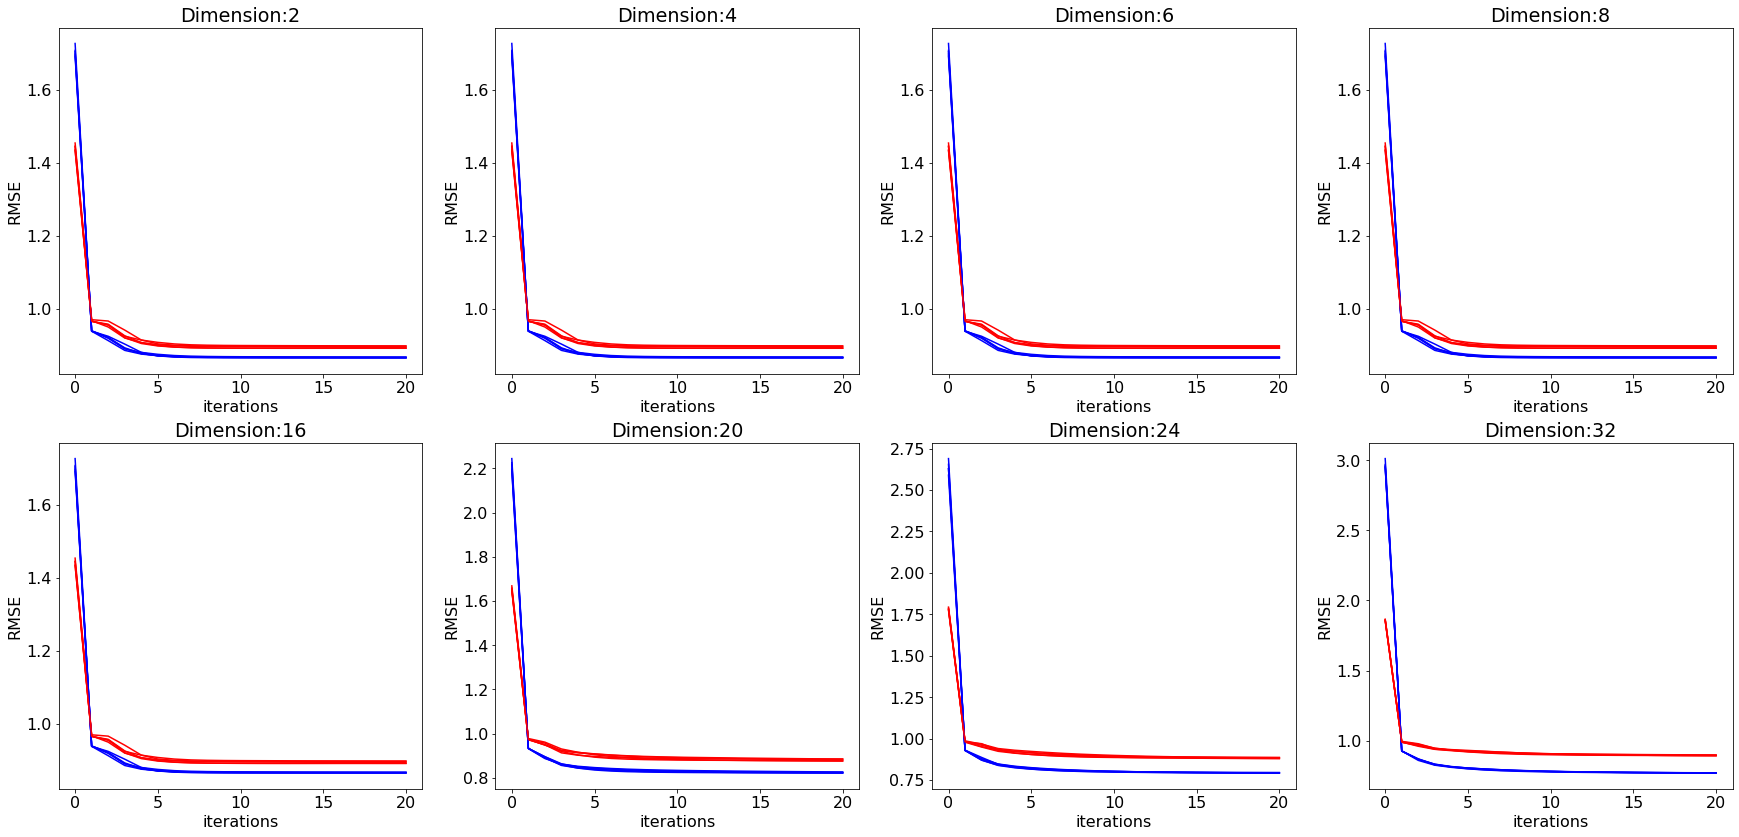

In [22]:
all_dims = [2,4,6,8,16,20,24,32]
plt.rcParams['font.size'] = '16'
figure, axis = plt.subplots(2,4, figsize=(30,14))
for i in range(4):
    for j in range(5):
        axis[0,i].plot(uv_train_RMSE_df.iloc[j],color='Blue')
        axis[0,i].plot(uv_test_RMSE_df.iloc[j], color='Red')
        axis[1,i].plot(uv_train_RMSE_df.iloc[j+i*5],color='Blue')
        axis[1,i].plot(uv_test_RMSE_df.iloc[j+i*5], color='Red')

        axis[0,i].set_title('Dimension:'+ str(all_dims[i]))
        axis[0,i].set_ylabel('RMSE')
        axis[0,i].set_xlabel('iterations')
        axis[1,i].set_title('Dimension:'+ str(all_dims[i+4]))
        axis[1,i].set_ylabel('RMSE')
        axis[1,i].set_xlabel('iterations')

In [23]:
train_rmse_mins = uv_train_RMSE_df.min(axis=1)
train_min_rmse_means = []
train_mae_mins = uv_train_MAE_df.min(axis=1)
train_min_mae_means = []

rmse_mins = uv_test_RMSE_df.min(axis=1)
min_rmse_means = []
mae_mins = uv_test_MAE_df.min(axis=1)
min_mae_means = []

i=0
while i < len(rmse_mins):
    train_min_rmse_means.append(np.mean(train_rmse_mins[i:i+5]))
    train_min_mae_means.append(np.mean(train_mae_mins[i:i+5]))

    min_rmse_means.append(np.mean(rmse_mins[i:i+5]))
    min_mae_means.append(np.mean(mae_mins[i:i+5]))
    i+=5

print("Mean results of 5-Fold cross-validation:")
print()
for i in range(len(all_dims)):
    print(f"Dimension {all_dims[i]}, Train RMSE: {train_min_rmse_means[i]:.4f}, Train MAE: {train_min_mae_means[i]:.4f}, Test RMSE: {min_rmse_means[i]:.4f}, Test MAE: {min_mae_means[i]:.4f}") 

Mean results of 5-Fold cross-validation:

Dimension 2, Train RMSE: 0.8669, Train MAE: 0.6820, Test RMSE: 0.8950, Test MAE: 0.7026
Dimension 4, Train RMSE: 0.8236, Train MAE: 0.6465, Test RMSE: 0.8807, Test MAE: 0.6869
Dimension 6, Train RMSE: 0.7927, Train MAE: 0.6211, Test RMSE: 0.8823, Test MAE: 0.6840
Dimension 8, Train RMSE: 0.7699, Train MAE: 0.6022, Test RMSE: 0.8952, Test MAE: 0.6899
Dimension 16, Train RMSE: 0.7009, Train MAE: 0.5425, Test RMSE: 0.9613, Test MAE: 0.7314
Dimension 20, Train RMSE: 0.6730, Train MAE: 0.5175, Test RMSE: 0.9894, Test MAE: 0.7512
Dimension 24, Train RMSE: 0.6484, Train MAE: 0.4954, Test RMSE: 1.0173, Test MAE: 0.7712
Dimension 32, Train RMSE: 0.6069, Train MAE: 0.4579, Test RMSE: 1.0731, Test MAE: 0.8097


In [24]:
rmse_iters_needed = uv_test_RMSE_df.idxmin(axis=1)
rmse_iters_means = []
mae_iters_needed = uv_test_RMSE_df.idxmin(axis=1)
mae_iter_means = []

i=0
while i < len(rmse_iters_needed):
    rmse_iters_means.append(np.mean(rmse_iters_needed[i:i+5]))
    mae_iter_means.append(np.mean(mae_iters_needed[i:i+5]))
    i+=5

for i in range(len(rmse_iters_means)):
    #the iteration value was the same for the RMSE and the MAE
    print(f"Dimension {all_dims[i]}, Mean value of iterations needed to reach minimum RMSE & MAE:{rmse_iters_means[i]}")  

Dimension 2, Mean value of iterations needed to reach minimum RMSE & MAE:17.2
Dimension 4, Mean value of iterations needed to reach minimum RMSE & MAE:20.0
Dimension 6, Mean value of iterations needed to reach minimum RMSE & MAE:20.0
Dimension 8, Mean value of iterations needed to reach minimum RMSE & MAE:20.0
Dimension 16, Mean value of iterations needed to reach minimum RMSE & MAE:9.2
Dimension 20, Mean value of iterations needed to reach minimum RMSE & MAE:7.8
Dimension 24, Mean value of iterations needed to reach minimum RMSE & MAE:7.0
Dimension 32, Mean value of iterations needed to reach minimum RMSE & MAE:7.0


<font size=5>
The lowest RMSE and MAE mean values in the test sets are obtained by the U,V matrixes of dimensions 4 and 6.
</font>
<br/><br/>

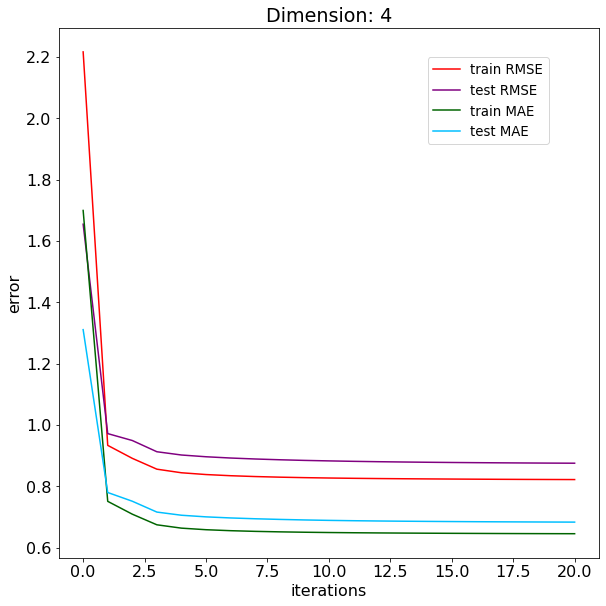

In [25]:
plt.rcParams['font.size'] = '16'
figure, axis = plt.subplots(1,1, figsize=(10,10))

axis.plot(uv_train_RMSE_df.iloc[6],color='red', label="train RMSE")
axis.plot(uv_test_RMSE_df.iloc[6], color='purple', label="test RMSE")

axis.plot(uv_train_MAE_df.iloc[6],color='darkgreen', label="train MAE")
axis.plot(uv_test_MAE_df.iloc[6], color='deepskyblue', label="test MAE")

axis.set_title('Dimension: 4')
axis.set_ylabel('error')
axis.set_xlabel('iterations')

figure.tight_layout(pad=4.0)
lines, labels =axis.get_legend_handles_labels()

figure.legend(labels, loc='upper right', fontsize= 'small',bbox_to_anchor=(0.85,0.85))

<br/><br/><br/>
<font size="5">
Matrix Factorization with Gradient Descent and Regularization
</font>

In [26]:
def weight_update(X,U,V,reg,lr,row,col):

    UV = np.dot(U[row],V[:,col])
    e = X[row,col] - UV
    U_row = U[row]
    V_col = V[:,col]
    new_u = U_row + lr*(2*e*V_col - (reg*U_row))
    new_v = V_col + lr*(2*e*U_row - (reg*V_col))

    return new_u, new_v

In [27]:
# the algorithm is very similar to the decomposition algorithm above,
# what changes is the weight update rule and the initial parameters

def matrix_factorization(ratings_df,test_df,
                        dim=2,normalize_data=True,
                        initial_value=None,noise_size=0.01,
                        regularization=0.05, learning_rate=0.005,
                        iters=50,debug=False):

    M_matrix, norm_val, U_matrix, V_matrix = create_U_V_M_matrixes(ratings_df,dim=dim,
                                                        initial_val=initial_value,noise_size=noise_size,
                                                        normalize=normalize_data,debug=debug)

    #we need this in order to keep track of the UserID and MovieID on our train set
    #in order to compare it with the test data later, and fill the gaps.
    M_df = ratings_df_to_matrix(ratings_df)
    global_val = ratings_df['Rating'].mean()
    
    #calculate initial RMSE for train and test
    TRAIN_RMSE  = []
    TRAIN_MAE   = []
    TEST_RMSE   = []
    TEST_MAE    = []
    
    UV_matrix = np.dot(U_matrix, V_matrix)
    curr_train_rmse = RMSE(M_matrix,UV_matrix)
    curr_train_mae = MAE(M_matrix,UV_matrix)
    TRAIN_RMSE.append(curr_train_rmse)
    TRAIN_MAE.append(curr_train_mae)
    #denormalize UV and calculate RMSE on test data

    UV_matrix = denormalize_UV(UV_matrix, norm_val)
    curr_test_rmse, curr_test_mae = evaluate_model( test_df, UV_matrix,
                                                    index=M_df.index,columns=M_df.columns,
                                                    global_val=global_val)
    TEST_RMSE.append(curr_test_rmse)
    TEST_MAE.append(curr_test_mae)

    
    if debug: 
        print("Mean value used to fill nan values:",global_val)
        print()
        print(f"initial train RMSE: {curr_train_rmse}, initial train MAE: {curr_train_mae}") 
        print(f"initial test RMSE: {curr_test_rmse}, initial test MAE: {curr_test_mae}")
        print()
    
    #taking all non nan values indexes
    M_indexes = np.argwhere(~np.isnan(M_matrix))
    range_M_indexes = list(range(len(M_indexes)-1))

    #updating weights..
    for iter in range(iters):      
        for i in range_M_indexes:
            (U_matrix[M_indexes[i][0]], 
            V_matrix[:,M_indexes[i][1]]) = weight_update(M_matrix,U_matrix,V_matrix,
                                                        regularization,learning_rate,
                                                        M_indexes[i][0],M_indexes[i][1])

        #calculate new RMSE
        UV_matrix = np.dot(U_matrix, V_matrix)
        curr_train_rmse = RMSE(M_matrix,UV_matrix) 
        curr_train_mae = MAE(M_matrix,UV_matrix) 
        TRAIN_RMSE.append(curr_train_rmse)
        TRAIN_MAE.append(curr_train_mae)
        
        #denormalize UV and calculate RMSE on test data 
        UV_matrix = denormalize_UV(UV_matrix,norm_val)
        curr_test_rmse, curr_test_mae = evaluate_model(test_df, UV_matrix,M_df.index,M_df.columns,global_val)
        TEST_RMSE.append(curr_test_rmse)
        TEST_MAE.append(curr_test_mae)
        if debug: 
            print(f'iteration {iter+1}, train RMSE: {curr_train_rmse}, train MAE {curr_train_mae}')
            print(f'iteration {iter+1}, test RMSE: {curr_test_rmse}, test MAE {curr_test_mae}')
            print()

    return TRAIN_RMSE, TRAIN_MAE, TEST_RMSE, TEST_MAE, U_matrix, V_matrix

In [28]:
#this is what we used to train our models, uncomment to run
"""dims = [8,10,16,24]
iters = 60
regularization=0.05
learning_rate=0.005

fac_train_rmses = []
fac_train_maes  = []
fac_test_rmses  = []
fac_test_maes   = []

for dim in dims:
    for split in range(n_splits):
        (curr_train_rmse, curr_train_mae,
        curr_test_rmse, curr_test_mae,
        curr_U, curr_V) = matrix_factorization( train_df[split],test_df[split],
                                                dim=dim,normalize_data=False,
                                                initial_value=0,noise_size=0.01,
                                                regularization=regularization,
                                                learning_rate=learning_rate,
                                                iters=iters,debug=True)

        fac_train_rmses.append(curr_train_rmse)
        fac_train_maes.append(curr_train_mae)
        fac_test_rmses.append(curr_test_rmse)
        fac_test_maes.append(curr_test_mae)


from numpy import savetxt
savetxt('results/MF/mf_train_rmses_numpy.csv', fac_train_rmses, delimiter=',')
savetxt('results/MF/mf_test_rmses_numpy.csv', fac_test_rmses, delimiter=',')
savetxt('results/MF/mf_train_maes_numpy.csv', fac_train_maes, delimiter=',')
savetxt('results/MF/mf_test_maes_numpy.csv', fac_test_maes, delimiter=',')
"""

"dims = [8,10,16,24]\niters = 60\nregularization=0.05\nlearning_rate=0.005\n\nfac_train_rmses = []\nfac_train_maes  = []\nfac_test_rmses  = []\nfac_test_maes   = []\n\nfor dim in dims:\n    for split in range(n_splits):\n        (curr_train_rmse, curr_train_mae,\n        curr_test_rmse, curr_test_mae,\n        curr_U, curr_V) = matrix_factorization( train_df[split],test_df[split],\n                                                dim=dim,normalize_data=False,\n                                                initial_value=0,noise_size=0.01,\n                                                regularization=regularization,\n                                                learning_rate=learning_rate,\n                                                iters=iters,debug=True)\n\n        fac_train_rmses.append(curr_train_rmse)\n        fac_train_maes.append(curr_train_mae)\n        fac_test_rmses.append(curr_test_rmse)\n        fac_test_maes.append(curr_test_mae)\n\n\nfrom numpy import savetxt\nsa

In [29]:
"""
dims = [30,36,40,50]
iters = 30
regularization=0.05
learning_rate=0.005

fac_train_rmses = []
fac_train_maes  = []
fac_test_rmses  = []
fac_test_maes   = []

for dim in dims:
    for split in range(n_splits):
        (curr_train_rmse, curr_train_mae,
        curr_test_rmse, curr_test_mae,
        curr_U, curr_V) = matrix_factorization( train_df[split],test_df[split],
                                                dim=dim,normalize_data=False,
                                                initial_value=0,noise_size=0.01,
                                                regularization=regularization,
                                                learning_rate=learning_rate,
                                                iters=iters,debug=True)

        fac_train_rmses.append(curr_train_rmse)
        fac_train_maes.append(curr_train_mae)
        fac_test_rmses.append(curr_test_rmse)
        fac_test_maes.append(curr_test_mae)


from numpy import savetxt
savetxt('results/MF_high/mf_train_rmses_numpy.csv', fac_train_rmses, delimiter=',')
savetxt('results/MF_high/mf_test_rmses_numpy.csv', fac_test_rmses, delimiter=',')
savetxt('results/MF_high/mf_train_maes_numpy.csv', fac_train_maes, delimiter=',')
savetxt('results/MF_high/mf_test_maes_numpy.csv', fac_test_maes, delimiter=',')
"""

"\ndims = [30,36,40,50]\niters = 30\nregularization=0.05\nlearning_rate=0.005\n\nfac_train_rmses = []\nfac_train_maes  = []\nfac_test_rmses  = []\nfac_test_maes   = []\n\nfor dim in dims:\n    for split in range(n_splits):\n        (curr_train_rmse, curr_train_mae,\n        curr_test_rmse, curr_test_mae,\n        curr_U, curr_V) = matrix_factorization( train_df[split],test_df[split],\n                                                dim=dim,normalize_data=False,\n                                                initial_value=0,noise_size=0.01,\n                                                regularization=regularization,\n                                                learning_rate=learning_rate,\n                                                iters=iters,debug=True)\n\n        fac_train_rmses.append(curr_train_rmse)\n        fac_train_maes.append(curr_train_mae)\n        fac_test_rmses.append(curr_test_rmse)\n        fac_test_maes.append(curr_test_mae)\n\n\nfrom numpy import savetxt\

<br/><br/>
<font size=4>

Let's study the RMSE and MAE of the Matrix Factorization method.<br/>
<br/>
Parameters used:<br/>
dimensions = [8,10,16,24,30,36,40,50]<br/>
iterations = 30-60<br/>
regularization = 0.05<br/>
learning rate = 0.005<br/>
initial weight value = 0<br/>
weight noise size = 0.01
</font>

In [30]:
mf_test_rmse_df = pd.read_csv('results/MF/mf_test_rmses_numpy.csv', header=None)
mf_train_rmse_df = pd.read_csv('results/MF/mf_train_rmses_numpy.csv', header=None)
mf_high_test_rmse_df = pd.read_csv('results/MF_high/mf_test_rmses_numpy.csv', header=None)
mf_high_train_rmse_df = pd.read_csv('results/MF_high/mf_train_rmses_numpy.csv', header=None)

mf_test_mae_df = pd.read_csv('results/MF/mf_test_maes_numpy.csv', header=None)
mf_train_mae_df = pd.read_csv('results/MF/mf_train_maes_numpy.csv', header=None)
mf_high_test_mae_df = pd.read_csv('results/MF_high/mf_test_maes_numpy.csv', header=None)
mf_high_train_mae_df = pd.read_csv('results/MF_high/mf_train_maes_numpy.csv', header=None)

In [31]:
test_RMSE_df = mf_test_rmse_df.copy()
test_RMSE_df = (test_RMSE_df.append(mf_high_test_rmse_df)).reset_index(drop=True)
train_RMSE_df = mf_train_rmse_df.copy()
train_RMSE_df = (train_RMSE_df.append(mf_high_train_rmse_df)).reset_index(drop=True)

test_MAE_df = mf_test_mae_df.copy()
test_MAE_df = (test_MAE_df.append(mf_high_test_mae_df)).reset_index(drop=True)
train_MAE_df = mf_train_mae_df.copy()
train_MAE_df = (train_MAE_df.append(mf_high_train_mae_df)).reset_index(drop=True)

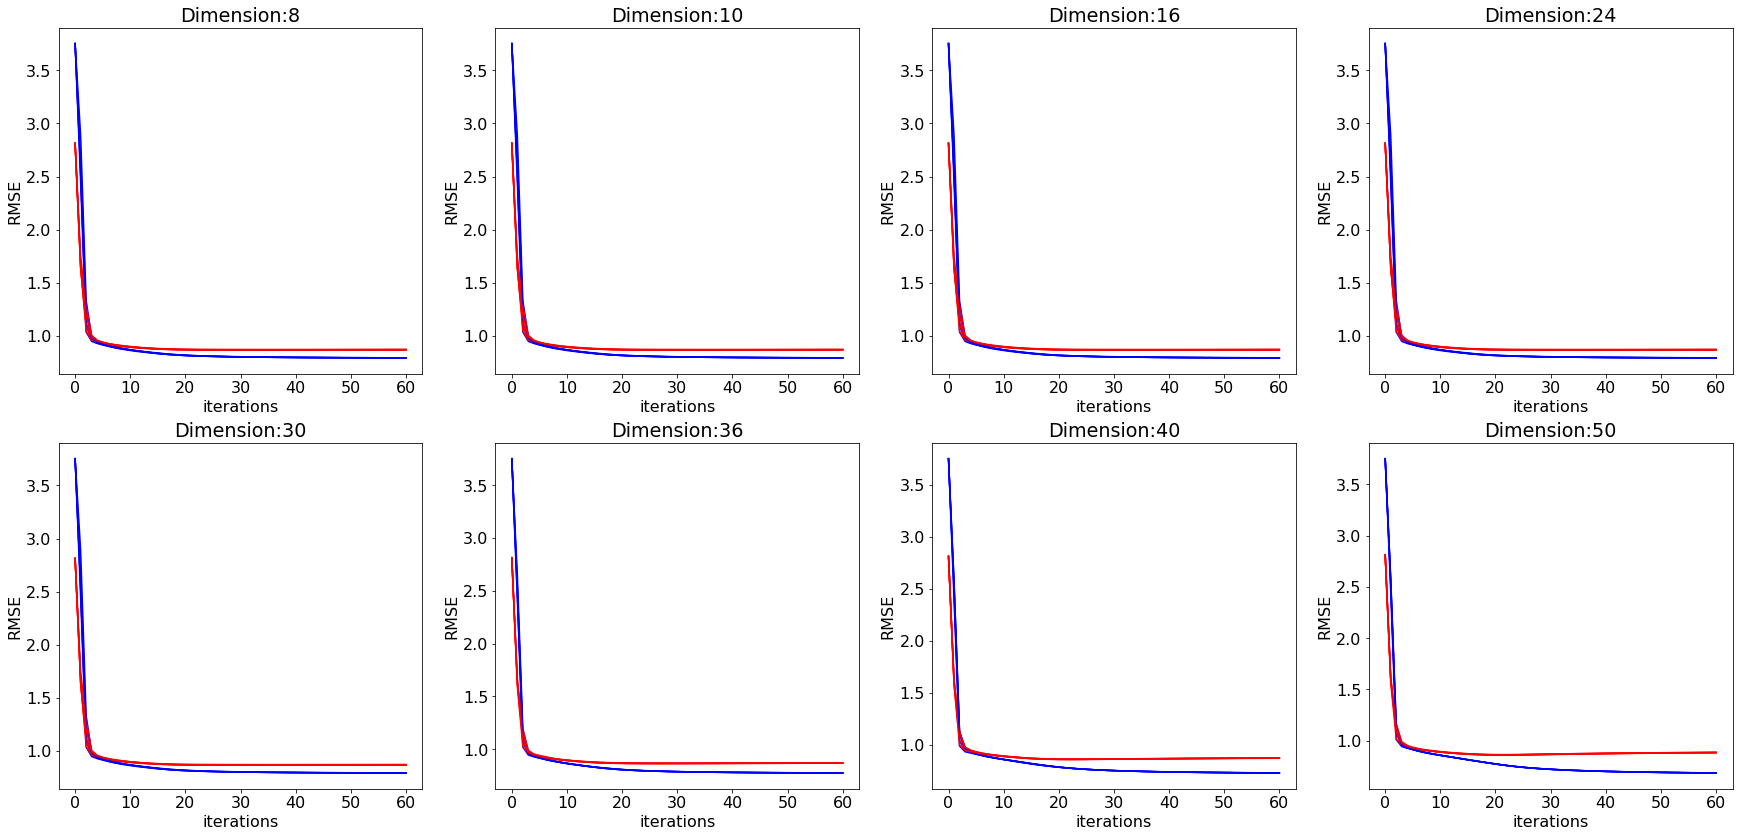

In [32]:
all_dims = [8,10,16,24,30,36,40,50]
plt.rcParams['font.size'] = '16'
figure, axis = plt.subplots(2,4, figsize=(30,14))

for i in range(4):
    for j in range(5):
        axis[0,i].plot(train_RMSE_df.iloc[j],color='Blue')
        axis[0,i].plot(test_RMSE_df.iloc[j], color='Red')
        axis[1,i].plot(train_RMSE_df.iloc[j+i*5],color='Blue')
        axis[1,i].plot(test_RMSE_df.iloc[j+i*5], color='Red')

        axis[0,i].set_title('Dimension:'+ str(all_dims[i]))
        axis[0,i].set_ylabel('RMSE')
        axis[0,i].set_xlabel('iterations')
        axis[1,i].set_title('Dimension:'+ str(all_dims[i+4]))
        axis[1,i].set_ylabel('RMSE')
        axis[1,i].set_xlabel('iterations')

In [33]:
train_rmse_mins = train_RMSE_df.min(axis=1)
train_min_rmse_means = []
train_mae_mins = train_MAE_df.min(axis=1)
train_min_mae_means = []

rmse_mins = test_RMSE_df.min(axis=1)
min_rmse_means = []
mae_mins = test_MAE_df.min(axis=1)
min_mae_means = []

i=0
while i < len(rmse_mins):
    train_min_rmse_means.append(np.mean(train_rmse_mins[i:i+5]))
    train_min_mae_means.append(np.mean(train_mae_mins[i:i+5]))

    min_rmse_means.append(np.mean(rmse_mins[i:i+5]))
    min_mae_means.append(np.mean(mae_mins[i:i+5]))
    i+=5

print()
print("Mean results of 5-Fold cross-validation:")
print()
for i in range(len(all_dims)):
    print(f"Dimension {all_dims[i]}, Train RMSE: {train_min_rmse_means[i]:.4f}, Train MAE: {train_min_mae_means[i]:.4f}, Test RMSE: {min_rmse_means[i]:.4f}, Test MAE: {min_mae_means[i]:.4f}")  


Mean results of 5-Fold cross-validation:

Dimension 8, Train RMSE: 0.7920, Train MAE: 0.6244, Test RMSE: 0.8675, Test MAE: 0.6800
Dimension 10, Train RMSE: 0.7741, Train MAE: 0.6101, Test RMSE: 0.8648, Test MAE: 0.6775
Dimension 16, Train RMSE: 0.7309, Train MAE: 0.5758, Test RMSE: 0.8620, Test MAE: 0.6759
Dimension 24, Train RMSE: 0.6839, Train MAE: 0.5380, Test RMSE: 0.8604, Test MAE: 0.6748
Dimension 30, Train RMSE: 0.6984, Train MAE: 0.5523, Test RMSE: 0.8596, Test MAE: 0.6738
Dimension 36, Train RMSE: 0.6792, Train MAE: 0.5375, Test RMSE: 0.8589, Test MAE: 0.6736
Dimension 40, Train RMSE: 0.6677, Train MAE: 0.5285, Test RMSE: 0.8589, Test MAE: 0.6736
Dimension 50, Train RMSE: 0.6413, Train MAE: 0.5078, Test RMSE: 0.8577, Test MAE: 0.6725


<font size=5>
The lowest RMSE and MAE values were achieved by the dimension 50 matrix.
</font>
<br/><br/>

In [34]:
rmse_iters_needed = test_RMSE_df.idxmin(axis=1)
rmse_iters_means = []
mae_iters_needed = test_RMSE_df.idxmin(axis=1)
mae_iter_means = []

i=0
while i < len(rmse_iters_needed):
    rmse_iters_means.append(np.mean(rmse_iters_needed[i:i+5]))
    mae_iter_means.append(np.mean(mae_iters_needed[i:i+5]))
    i+=5

for i in range(len(rmse_iters_means)):
    #the iteration value was the same for the RMSE and the MAE
    print(f"Dimension {all_dims[i]}, Mean value of iterations needed to reach minimum RMSE & MAE:{rmse_iters_means[i]}")  

Dimension 8, Mean value of iterations needed to reach minimum RMSE & MAE:32.4
Dimension 10, Mean value of iterations needed to reach minimum RMSE & MAE:27.4
Dimension 16, Mean value of iterations needed to reach minimum RMSE & MAE:22.4
Dimension 24, Mean value of iterations needed to reach minimum RMSE & MAE:21.2
Dimension 30, Mean value of iterations needed to reach minimum RMSE & MAE:21.0
Dimension 36, Mean value of iterations needed to reach minimum RMSE & MAE:20.8
Dimension 40, Mean value of iterations needed to reach minimum RMSE & MAE:20.6
Dimension 50, Mean value of iterations needed to reach minimum RMSE & MAE:20.2


<br/><br/>
<font size=5>
RMSE and MAE graphs of the matrix decomposition with dimension 50</font>

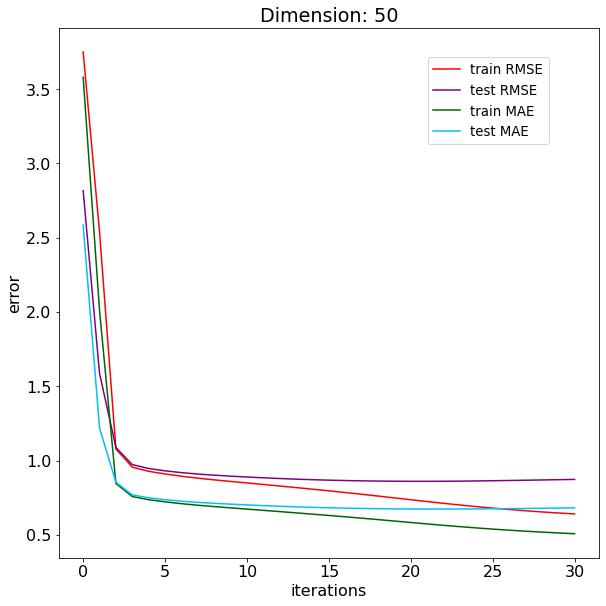

In [35]:
plt.rcParams['font.size'] = '16'
figure, axis = plt.subplots(1,1, figsize=(10,10))

axis.plot(train_RMSE_df.iloc[-1],color='red', label="train RMSE")
axis.plot(test_RMSE_df.iloc[-1], color='purple', label="test RMSE")

axis.plot(train_MAE_df.iloc[-1],color='darkgreen', label="train MAE")
axis.plot(test_MAE_df.iloc[-1], color='deepskyblue', label="test MAE")

axis.set_title('Dimension: 50')
axis.set_ylabel('error')
axis.set_xlabel('iterations')

figure.tight_layout(pad=4.0)
lines, labels =axis.get_legend_handles_labels()

figure.legend(labels, loc='upper right', fontsize= 'small',bbox_to_anchor=(0.85,0.85))

In [36]:
"""fac_train_rmses = []
fac_train_maes  = []
fac_test_rmses  = []
fac_test_maes   = []

for split in range(n_splits):
        print(f"curr split: {split}")
        (curr_train_rmse, curr_train_mae,
        curr_test_rmse, curr_test_mae,
        curr_U, curr_V) = matrix_factorization( train_df[split],test_df[split],
                                                dim=50,normalize_data=False,
                                                initial_value=0,noise_size=0.01,
                                                regularization=0.01,
                                                learning_rate=0.001,
                                                iters=75,debug=False)

        fac_train_rmses.append(curr_train_rmse)
        fac_train_maes.append(curr_train_mae)
        fac_test_rmses.append(curr_test_rmse)
        fac_test_maes.append(curr_test_mae)

        print(curr_test_rmse)
        print()

train_rmse_np = np.array(fac_train_rmses)
train_mae_np = np.array(fac_train_maes)
test_rmse_np = np.array(fac_test_rmses)
test_mae_np = np.array(fac_test_maes)

from numpy import savetxt
savetxt('results/MF_optimal/mf_train_rmses_optimal.csv', train_rmse_np, delimiter=',')
savetxt('results/MF_optimal/mf_test_rmses_optimal.csv', test_rmse_np, delimiter=',')
savetxt('results/MF_optimal/mf_train_maes_optimal.csv', train_mae_np, delimiter=',')
savetxt('results/MF_optimal/mf_test_maes_optimal.csv', test_mae_np, delimiter=',')"""

'fac_train_rmses = []\nfac_train_maes  = []\nfac_test_rmses  = []\nfac_test_maes   = []\n\nfor split in range(n_splits):\n        print(f"curr split: {split}")\n        (curr_train_rmse, curr_train_mae,\n        curr_test_rmse, curr_test_mae,\n        curr_U, curr_V) = matrix_factorization( train_df[split],test_df[split],\n                                                dim=50,normalize_data=False,\n                                                initial_value=0,noise_size=0.01,\n                                                regularization=0.01,\n                                                learning_rate=0.001,\n                                                iters=75,debug=False)\n\n        fac_train_rmses.append(curr_train_rmse)\n        fac_train_maes.append(curr_train_mae)\n        fac_test_rmses.append(curr_test_rmse)\n        fac_test_maes.append(curr_test_mae)\n\n        print(curr_test_rmse)\n        print()\n\ntrain_rmse_np = np.array(fac_train_rmses)\ntrain_mae_np = np.a

In [37]:
train_rmses = pd.read_csv('results/MF_optimal/mf_train_rmses_optimal.csv', header=None)
test_rmses = pd.read_csv('results/MF_optimal/mf_test_rmses_optimal.csv', header=None)
train_maes = pd.read_csv('results/MF_optimal/mf_train_maes_optimal.csv', header=None)
test_maes = pd.read_csv('results/MF_optimal/mf_test_maes_optimal.csv', header=None)

In [38]:
print("Mean values achieved for d=50, learning_rate=0.001 and regularization=0.01")
print(f"Train RMSE {train_rmses.min(axis=1).mean()}, Train MAE {train_maes.min(axis=1).mean()}, Test RMSE {test_rmses.min(axis=1).mean()}, Test MAE {test_maes.min(axis=1).mean()}")
print(f"Optimal RMSE and MAE found at iteration: {test_rmses.idxmin(axis=1).mean()}")

Mean values achieved for d=50, learning_rate=0.001 and regularization=0.01
Train RMSE 0.6937033890854567, Train MAE 0.544099474000232, Test RMSE 0.8509465368176276, Test MAE 0.6645211552434461
Optimal RMSE and MAE found at iteration: 63.0
